In [1]:
import pymongo
from pymongo import MongoClient
from google.cloud import bigquery
from bson import ObjectId
from google.cloud import bigquery_storage_v1
from functools import partialmethod

import datetime as dt
import pandas as pd
import numpy as np
import requests
import json

from sklearn import preprocessing
import matplotlib.pyplot as plt

1. Посмотреть зависимость между количеством шейпов, кол-вом цветов и простотой картинки, чтобы четко определять что для пользователя представляется простой картинкой.
2. Оценить аудиторию, которая красит этот тег. Является ли это отдельным пластом аудитории, которая красит только простые картинки, или это то, с чего юзер начинает и потом конвертируется в обычного пользователя и идет по другим тегам.
3. На какой день пользователь находит тег Simple и начинает его красить, как долго красит его, красит ли другие теги ?
4. Есть ли зависимость, что если человек начинает красить с простых картинок, то он дольше держится в приложении ?
5. Сколько живет пользователь этого тега ? Т.е. может они отваливаются через неделю и тогда нам не интересно это направление.

In [2]:
# Забираем все картинки, бьем их по категориям, смотрим на корреляцию между количеством шейпов и коэффициентом 
# закрашивания картинки 


# Забираем весь фид со ссылками на векторные картинки
# 'https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419' #"DAILY PRODUCTION" 
# 'https://cdnmains3.color.auragames.co/feeds/5ef4559473613e00112db462' #"BONUS PRODUCTION"

urls = ['https://cdnmains3.color.auragames.co/feeds/5e4e90dee8a3eb6eaaa117f7',
       'https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419',
       'https://cdnmains3.color.auragames.co/feeds/5ef4559473613e00112db462'] 
all_feed = pd.DataFrame()

for i in urls:
    url = requests.get(i)
    all_feed_ = url.json()
    all_feed_ = pd.DataFrame(all_feed_['items']) 
    all_feed_ = all_feed_[['id', 'svg', 'tags', 'createTimestamp']]
    all_feed_['feed_id'] = i
    all_feed = pd.concat([all_feed, all_feed_], ignore_index=True, sort=False)    

all_feed.createTimestamp.replace('Mon Mar 01 2021 13:56:16 GMT+0000 (Coordinated Universal Time)', 
                                   '2021-03-01T13:56:16.000Z', inplace=True)
all_feed.createTimestamp.replace('Tue Mar 02 2021 11:47:09 GMT+0000 (Coordinated Universal Time)', 
                                   '2021-03-02T11:47:09.000Z', inplace=True)
all_feed['createTimestamp'] = pd.to_datetime(all_feed['createTimestamp']).dt.tz_localize(None)

all_feed = all_feed.explode('tags')
all_feed['tags'] = np.where(all_feed.feed_id=='https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419', 
                            'daily', all_feed.tags)

In [3]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
select b.picture_id, pinished_pics, started_pics, pinished_pics/started_pics as finish_coef	
from (
    SELECT picture_id, count(distinct customer_user_id) as pinished_pics 
    FROM `goingtoclouds.aggregated_data.picture_finish`
    where country !='Belarus'
    group by picture_id) as a
right JOIN (
    SELECT picture_id, count(distinct customer_user_id) as started_pics 
    FROM `goingtoclouds.aggregated_data.picture_start`
    where country !='Belarus'
    group by picture_id
) as b
on a.picture_id=b.picture_id
'''
all_pics = client.query(sql, project=project_id).to_dataframe()
all_pics = all_pics[all_pics.picture_id.isin(all_feed.id.unique().tolist())]

In [5]:
all_feed = all_feed.merge(all_pics, how='left', left_on='id', right_on='picture_id')
all_feed = all_feed[~all_feed.picture_id.isna()]

# Извлекаем старые картинки
new_pectures_time = pd.to_datetime(dt.datetime.utcnow() - dt.timedelta(hours=48))
all_feed = all_feed[all_feed['createTimestamp'] < new_pectures_time]

In [6]:
# Забираем количество шейпов и цветов из монго
login = 'user1'
password = 'cPvclw4i57sAFKFk'
db_name = 'hc-prod'

client = MongoClient('mongodb+srv://{}:{}@hc-prod-db.qzq5d.mongodb.net/@hc-prod-db.qzq5d.mongodb.net/{}?retryWrites=true&w=majority'.format(login, password, db_name))
db = client.hc_prod

json_data_image = db['Image'].find({})

img_arr = all_feed.id.tolist()
images = pd.DataFrame()

tesselatorCoreInfo_arr = []
for document in json_data_image:
    id = document['_id'].__str__()        
    if id in img_arr:            
        if 'totalshapesCount' in document['tesselatorCoreInfo']:
            tesselatorCoreInfo = document['tesselatorCoreInfo']
            totalshapesCount = tesselatorCoreInfo['totalshapesCount']
            colorsCount = tesselatorCoreInfo['colorsCount']
            tesselatorCoreInfo_arr.append({'id': id, 'totalshapesCount': totalshapesCount, 
                                           'colorsCount': colorsCount}) 
images = pd.json_normalize(tesselatorCoreInfo_arr, max_level=0)             

In [7]:
correlations = all_feed[['id', 'svg', 'createTimestamp', 'feed_id', 'tags', "pinished_pics", 'started_pics', 
                                                     'finish_coef']].merge(images, how='left', on='id')

In [8]:
correlations.columns = ['id', 'svg', 'createTimestamp', 'feed_id', 'tags', 'finished_users',
       'started_users', 'finish_coef', 'totalshapesCount', 'colorsCount']

In [11]:
correlations['rank'] = correlations.groupby("tags")["finish_coef"].rank("dense", ascending=False)

In [13]:
corr = correlations[correlations['rank']<=20]

corr.sort_values(by=['tags', 'rank'], inplace=True)
corr.to_csv('top_20_by_finish_coef.csv')

<ipython-input-13-cf042afa6370>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr.sort_values(by=['tags', 'rank'], inplace=True)


In [16]:
correlations['rank'] = correlations.groupby("tags")["finished_users"].rank("dense", ascending=False)

corr = correlations[correlations['rank']<=20]

corr.sort_values(by=['tags', 'rank'], inplace=True)
corr.to_csv('top_20_by_finished_users.csv')

<ipython-input-16-1e4c056b014c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr.sort_values(by=['tags', 'rank'], inplace=True)


In [17]:
corr

id          svg createTimestamp  \
2196  5f2c0817661e2b001132d048  ~utyeZm.svg      2020-08-22   
2131  5f34f780e0a5ec0018d42f44  UeFhrM-.svg      2020-08-29   
1913  5f4d13cf5cce5f001199de54  cZaI7ZY.svg      2020-09-18   
1045  5fca3d8201813a0018df0d4e  RZChQ4h.svg      2020-12-16   
1080  5fca358801813a0018df0d4b  BUR61~b.svg      2020-12-13   
...                        ...          ...             ...   
2721  5ef9dee0fd1a610011e1c324  6b7S0Hl.svg      2020-07-02   
1755  5f6cac438d976d0011d546f2  20-5NCL.svg      2020-10-06   
1859  5f63b12dfa2af900110633c8  .VsoqWz.svg      2020-09-25   
797   5fc7b91a01813a0018df0d12  g1~mfOp.svg      2021-01-08   
4541  5f4cc4a55cce5f001199de41  MCUBvV0.svg      2020-08-31   

                                                feed_id      tags  \
2196  https://cdnmains3.color.auragames.co/feeds/5e4...   animals   
2131  https://cdnmains3.color.auragames.co/feeds/5e4...   animals   
1913  https://cdnmains3.color.auragames.co/feeds/5e4...   animals   
1045  https://cdnmains3.color.auragames.co/feeds/5e4...   animals   
1080  https://cdnmains3.color.auragames.co/feeds/5e4...   animals   
...                                                 ...       ...   
2721  https://cdnmains3.color.auragames.co/feeds/5e4...  vehicles   
1755  https://cdnmains3.color.auragames.co/feeds/5e4...  vehicles   
1859  https://cdnmains3.color.auragames.co/feeds/5e4...  vehicles   
797   https://cdnmains3.color.auragames.co/feeds/5e4...  vehicles   
4541  https://cdnmains3.color.auragames.co/feeds/5ef...       NaN   

      finished_users  started_users  finish_coef  totalshapesCount  \
2196         24385.0        29876.0     0.816207             745.0   
2131         20833.0        23256.0     0.895812             501.0   
1913         20726.0        23197.0     0.893478             507.0   
1045         19939.0        21829.0     0.913418             234.0   
1080         19455.0        23445.0     0.829814             657.0   
...              ...            ...          ...               ...   
2721         11604.0        12842.0     0.903598             585.0   
1755         11565.0        13047.0     0.886411             765.0   
1859         11417.0        12849.0     0.888552             712.0   
797          11400.0        12545.0     0.908729             415.0   
4541           331.0          361.0     0.916898             347.0   

      colorsCount  rank  
2196         83.0   1.0  
2131         64.0   2.0  
1913         39.0   3.0  
1045         55.0   4.0  
1080        105.0   5.0  
...           ...   ...  
2721        122.0  17.0  
1755         76.0  18.0  
1859         53.0  19.0  
797          40.0  20.0  
4541         59.0   1.0  

[461 rows x 11 columns]

In [23]:
correlations[correlations.tags=='simple'].corr()

# tt = correlations[['id', 'tags', 'finish_coef', 'totalshapesCount', 'colorsCount']].drop_duplicates().groupby('tags').corr(method='spearman')
# tt.to_csv('corelations.csv')

pinished_pics  started_pics  finish_coef  totalshapesCount  \
pinished_pics          1.000000      0.996133     0.280387         -0.334745   
started_pics           0.996133      1.000000     0.201087         -0.288500   
finish_coef            0.280387      0.201087     1.000000         -0.710532   
totalshapesCount      -0.334745     -0.288500    -0.710532          1.000000   
colorsCount           -0.232974     -0.198101    -0.464251          0.599240   

                  colorsCount  
pinished_pics       -0.232974  
started_pics        -0.198101  
finish_coef         -0.464251  
totalshapesCount     0.599240  
colorsCount          1.000000

Text(0.5, 1.0, 'Number of shapes vs. finish coefficient for simple tag')

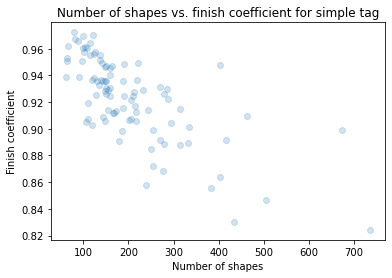

In [28]:
plt.scatter(correlations[correlations.tags=='simple'].totalshapesCount, 
            correlations[correlations.tags=='simple'].finish_coef, alpha=0.2)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for simple tag')

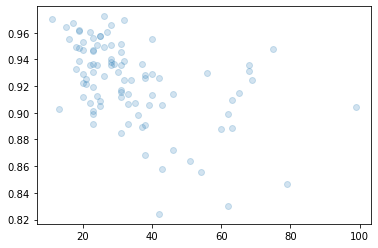

In [26]:
plt.scatter(correlations[correlations.tags=='simple'].colorsCount, 
            correlations[correlations.tags=='simple'].finish_coef, alpha=0.2)

Text(0.5, 1.0, 'Number of shapes vs. Number of colors')

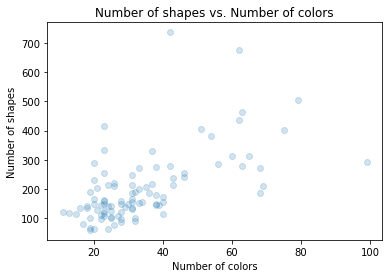

In [30]:
plt.scatter(correlations[correlations.tags=='simple'].colorsCount, 
            correlations[correlations.tags=='simple'].totalshapesCount, alpha=0.2)

plt.xlabel('Number of colors')
plt.ylabel('Number of shapes')
plt.title('Number of shapes vs. Number of colors')

### Смотрим на корреляции в зависимости от категорий, в которой тэг симтл красят

In [32]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
select b.picture_id, b.category, pinished_pics, started_pics, pinished_pics/started_pics as finish_coef	
from (
    SELECT picture_id, category, count(distinct customer_user_id) as pinished_pics 
    FROM `goingtoclouds.aggregated_data.picture_finish`
    where country !='Belarus'
    group by picture_id, category) as a
right JOIN (
    SELECT picture_id, category, count(distinct customer_user_id) as started_pics 
    FROM `goingtoclouds.aggregated_data.picture_start`
    where country !='Belarus'
    group by picture_id, category
) as b
on a.picture_id=b.picture_id 
and a.category=b.category
'''

category_pics = client.query(sql, project=project_id).to_dataframe()
category_pics = category_pics[category_pics.picture_id.isin(all_feed.id.unique().tolist())]
category_pics = category_pics[~category_pics.finish_coef.isna()]
category_pics = category_pics.merge(images, how='left', right_on='id', left_on='picture_id')
category_pics = category_pics[category_pics.started_pics!=1]

In [38]:
simple_categories = category_pics[category_pics.picture_id.isin(correlations[correlations.tags=='simple'].id.tolist())]

In [43]:
simple_categories.groupby('category').agg({'pinished_pics':'sum', 'started_pics':'sum'})

pinished_pics  started_pics
category                             
all            490503.0        535383
animals          3069.0          3462
bonus               4.0             4
daily               2.0             4
fantasy           766.0           829
food             3914.0          4169
holidays         4383.0          4978
mandalas        12900.0         13351
people            640.0           730
simple         405200.0        433315

In [45]:
correlations[correlations.tags=='simple'].agg({'pinished_pics':'sum', 'started_pics':'sum'})

pinished_pics    921082.0
started_pics     995503.0
dtype: float64

In [48]:
correlations[correlations.tags=='simple'].to_csv('simple.csv')

### Тэг симпл и ретеншн

4.	Есть ли зависимость, что если человек начинает красить с простых картинок, то он дольше держится в приложении ?
5.	Сколько живет пользователь этого тега ? Т.е. может они отваливаются через неделю и тогда нам не интересно это направление.


In [62]:
# Извлекаем пользователей, которые закрасили как минимум 3 картинки из симпл в первые 7 дней жизни. Смотрим их ретеншн
sql = '''
with pic_finish as (
    select customer_user_id, picture_id,  event_date,
    count(distinct picture_id) over (partition by customer_user_id) as total_simple,
    min(event_date) over (partition by customer_user_id) as min_event_date
    from `goingtoclouds.aggregated_data.picture_finish`
    where picture_id in (
        select picture_id from `goingtoclouds.feed.all_feed` where tags='simple')
        and country != 'Belarus'  
)

select b.customer_user_id, install_day, event_date, min_event_date, picture_id, total_simple, 
    date_diff(min_event_date, install_day, day) as first_simple_pic
from (
    select distinct customer_user_id, 
        min(install_day) over (partition by customer_user_id) as install_day
    from `goingtoclouds.aggregated_data.roas_v4`) as a
right join ( 
    select * 
    from pic_finish
    where total_simple>2
) as b
on a.customer_user_id = b.customer_user_id
'''

simple_reten = client.query(sql, project=project_id).to_dataframe()

In [76]:
df = simple_reten[['customer_user_id', 'total_simple', 'first_simple_pic']].drop_duplicates()
df = df[df.first_simple_pic>=0]
df

customer_user_id  total_simple  first_simple_pic
0                    240             3             321.0
11                   900             3             119.0
14                   976             3             237.0
17                  1279             6              90.0
23                  1320             6             206.0
...                  ...           ...               ...
813764            785797             6               0.0
813770            785894             5               0.0
813775            786141             4               1.0
813779            788852            21               0.0
813800            789276             3               0.0

[58951 rows x 3 columns]

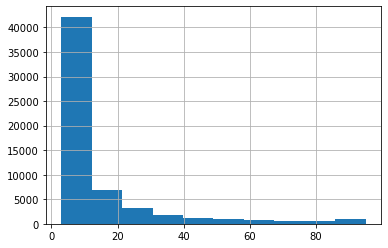

In [77]:
df.total_simple.hist()

Text(0.5, 1.0, 'Характер аудитории, которая красит simple картинки')

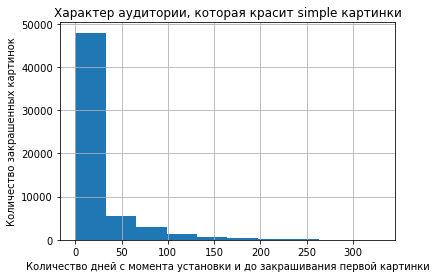

In [87]:
df.first_simple_pic.hist()

plt.xlabel('Количество дней с момента установки и до закрашивания первой картинки')
plt.ylabel('Количество закрашенных картинок')
plt.title('Характер аудитории, которая красит simple картинки')

In [119]:
# Ищем ретеншн этой аудитории

sql = '''
with pic_finish as (
    select customer_user_id, picture_id,  event_date,
    count(distinct picture_id) over (partition by customer_user_id) as total_simple,
    min(event_date) over (partition by customer_user_id) as min_event_date
    from `goingtoclouds.aggregated_data.picture_finish`
    where picture_id in (
        select picture_id from `goingtoclouds.feed.all_feed` where tags='simple')
        and country != 'Belarus'  
), 

first_install as (
    select distinct customer_user_id, 
        min(install_day) over (partition by customer_user_id) as install_day
    from `goingtoclouds.aggregated_data.roas_v4`
),

simple_users as (
    select distinct customer_user_id
    from (select b.customer_user_id, install_day, event_date, min_event_date, picture_id, total_simple, 
        date_diff(min_event_date, install_day, day) as first_simple_pic
    from (
        select distinct customer_user_id, 
            min(install_day) over (partition by customer_user_id) as install_day
        from `goingtoclouds.aggregated_data.roas_v4`) as a
    right join ( 
        select * 
        from pic_finish
        where total_simple>2
    ) as b
    on a.customer_user_id = b.customer_user_id
    where date_diff(min_event_date, install_day, day)>=0 and date_diff(min_event_date, install_day, day)<=10)
)

select cohort_date, count(distinct customer_user_id) as returned_users
from (
    select a.customer_user_id, event_date, install_day, 
        date_diff(event_date, install_day, day) as cohort_date
    from (
        select distinct customer_user_id, event_date
        from `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch`
        where customer_user_id in (select * from simple_users)
    ) as a 
    left join first_install
    on first_install.customer_user_id=a.customer_user_id
    where date_diff(event_date, install_day, day)>=0
)
group by cohort_date
order by cohort_date
'''
cohort_reten = client.query(sql, project=project_id).to_dataframe()


sql = '''
with pic_finish as (
    select customer_user_id, picture_id,  event_date,
    count(distinct picture_id) over (partition by customer_user_id) as total_simple,
    min(event_date) over (partition by customer_user_id) as min_event_date
    from `goingtoclouds.aggregated_data.picture_finish`
    where picture_id in (
        select picture_id from `goingtoclouds.feed.all_feed` where tags='simple')
        and country != 'Belarus'  
), 

first_install as (
    select distinct customer_user_id, 
        min(install_day) over (partition by customer_user_id) as install_day
    from `goingtoclouds.aggregated_data.roas_v4`
),

simple_users as (
    select distinct customer_user_id
    from (select b.customer_user_id, install_day, event_date, min_event_date, picture_id, total_simple, 
        date_diff(min_event_date, install_day, day) as first_simple_pic
    from (
        select distinct customer_user_id, 
            min(install_day) over (partition by customer_user_id) as install_day
        from `goingtoclouds.aggregated_data.roas_v4`) as a
    right join ( 
        select * 
        from pic_finish
        where total_simple>2
    ) as b
    on a.customer_user_id = b.customer_user_id
    where date_diff(min_event_date, install_day, day)>=0 and date_diff(min_event_date, install_day, day)<=10)
)

select count(distinct customer_user_id) as returned_users
from (
    select a.customer_user_id, event_date, install_day, 
        date_diff(event_date, install_day, day) as cohort_date
    from (
        select distinct customer_user_id, event_date
        from `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch`
        where customer_user_id in (select * from simple_users)
    ) as a 
    left join first_install
    on first_install.customer_user_id=a.customer_user_id
    where date_diff(event_date, install_day, day)>=0
)
'''

total_users = client.query(sql, project=project_id).to_dataframe()

In [120]:
total_users.returned_users[0]

38018

In [125]:
# 34598/38018
cohort_reten['retention'] = round(cohort_reten['returned_users']/total_users.returned_users[0], 4)

Text(0.5, 1.0, 'Ретеншн аудитории, которая красит simple картинки')

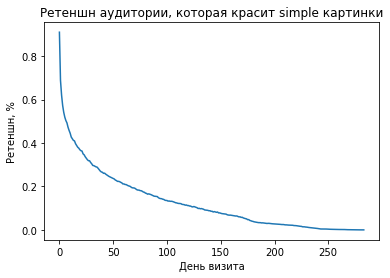

In [126]:
plt.plot(cohort_reten['cohort_date'], cohort_reten['retention'])

plt.xlabel('День визита')
plt.ylabel('Ретеншн, %')
plt.title('Ретеншн аудитории, которая красит simple картинки')

In [130]:
cohort_reten[["cohort_date", "returned_users", "retention"]].head(30)

cohort_date  returned_users  retention
0             0           34598     0.9100
1             1           26169     0.6883
2             2           23603     0.6208
3             3           21794     0.5733
4             4           20586     0.5415
5             5           19733     0.5190
6             6           19133     0.5033
7             7           18729     0.4926
8             8           17973     0.4727
9             9           17405     0.4578
10           10           16914     0.4449
11           11           16244     0.4273
12           12           15964     0.4199
13           13           15663     0.4120
14           14           15575     0.4097
15           15           15086     0.3968
16           16           14788     0.3890
17           17           14472     0.3807
18           18           14301     0.3762
19           19           14030     0.3690
20           20           13859     0.3645
21           21           13799     0.3630
22           22           13302     0.3499
23           23           13138     0.3456
24           24           12798     0.3366
25           25           12524     0.3294
26           26           12285     0.3231
27           27           12104     0.3184
28           28           12105     0.3184
29           29           11802     0.3104

### C какой переиодичностью мы постим эти картинки

In [146]:
import datetime as dt

all_feed['date'] = pd.to_datetime(all_feed.createTimestamp).dt.date

In [160]:
all_feed[(all_feed.tags=='simple') & 
         (all_feed.date>=dt.date(2020, 11, 1))].agg({'date': ['min', 'max', 'nunique']})

date
min      2020-11-02
max      2021-03-02
nunique          40

In [161]:
dt.date(2021, 3, 2) - dt.date(2020, 11, 1)

datetime.timedelta(days=121)

In [162]:
121/40

3.025

In [155]:
all_feed[all_feed.tags=='simple']

id          svg       type    tags  \
156   602fae73778b890011d97c67  o231n3Z.svg  published  simple   
192   603757546a34cf0011e86ccb  FupoeFQ.svg  published  simple   
210   6034e0066a34cf0011e86cae  kD~yudP.svg  published  simple   
229   6033c4a2778b890011d97c96  ~eXBf_9.svg  published  simple   
242   602fbde6778b890011d97c70  pV5qTY-.svg  published  simple   
...                        ...          ...        ...     ...   
3655  5e833ee31f1ec26f545a9574  qtgICF~.svg  published  simple   
3660  5e82f5b11f1ec26f545a9560  pWqGNe2.svg  published  simple   
3661  5e8320f21f1ec26f545a9565  mfx~q2I.svg  published  simple   
3662  5e82ec841f1ec26f545a955c  WY-bqnT.svg  published  simple   
3922  5e4fb75104aea3784208a450  fAa17EI.svg  published  simple   

             createTimestamp  \
156  2021-03-02 00:00:00.000   
192  2021-02-26 00:00:00.000   
210  2021-02-24 00:00:00.000   
229  2021-02-23 00:00:00.000   
242  2021-02-21 00:00:00.000   
...                      ...   
3655 2020-03-31 13:00:19.338   
3660 2020-03-31 07:48:01.441   
3661 2020-03-31 10:52:33.953   
3662 2020-03-31 07:08:51.996   
3922 2020-02-21 10:56:17.297   

                                                feed_id  \
156   https://cdnmains3.color.auragames.co/feeds/5e4...   
192   https://cdnmains3.color.auragames.co/feeds/5e4...   
210   https://cdnmains3.color.auragames.co/feeds/5e4...   
229   https://cdnmains3.color.auragames.co/feeds/5e4...   
242   https://cdnmains3.color.auragames.co/feeds/5e4...   
...                                                 ...   
3655  https://cdnmains3.color.auragames.co/feeds/5e4...   
3660  https://cdnmains3.color.auragames.co/feeds/5e4...   
3661  https://cdnmains3.color.auragames.co/feeds/5e4...   
3662  https://cdnmains3.color.auragames.co/feeds/5e4...   
3922  https://cdnmains3.color.auragames.co/feeds/5e4...   

                    picture_id  pinished_pics  started_pics  finish_coef  \
156   602fae73778b890011d97c67         5976.0        6982.0     0.855915   
192   603757546a34cf0011e86ccb         7496.0        8341.0     0.898693   
210   6034e0066a34cf0011e86cae         6223.0        6981.0     0.891420   
229   6033c4a2778b890011d97c96         4636.0        5097.0     0.909555   
242   602fbde6778b890011d97c70         7217.0        8692.0     0.830304   
...                        ...            ...           ...          ...   
3655  5e833ee31f1ec26f545a9574         5057.0        5263.0     0.960859   
3660  5e82f5b11f1ec26f545a9560         5211.0        5649.0     0.922464   
3661  5e8320f21f1ec26f545a9565         6070.0        6308.0     0.962270   
3662  5e82ec841f1ec26f545a955c         7076.0        7618.0     0.928853   
3922  5e4fb75104aea3784208a450         6351.0        6868.0     0.924723   

            date  
156   2021-03-02  
192   2021-02-26  
210   2021-02-24  
229   2021-02-23  
242   2021-02-21  
...          ...  
3655  2020-03-31  
3660  2020-03-31  
3661  2020-03-31  
3662  2020-03-31  
3922  2020-02-21  

[95 rows x 11 columns]

### Какие еще тэги красят пользователи тэга simple

In [164]:
sql = '''
select customer_user_id, tags, count(distinct a.picture_id) as finished_pics_feed
from (
    select customer_user_id, picture_id
    from `goingtoclouds.aggregated_data.picture_finish`
    where country != 'Belarus' and customer_user_id not in (31, 0)) as a
left join (
    select picture_id, 
    if(feed_type='daily_feed', 'daily', tags) as tags
    from `goingtoclouds.feed.all_feed`
) as b 
on a.picture_id=b.picture_id
where tags is not null
group by customer_user_id, tags
'''
finished_pics_feed = client.query(sql, project=project_id).to_dataframe()

In [165]:
finished_pics_feed 

customer_user_id             tags  finished_pics_feed
0                  512595              art                  11
1                  579737              art                   1
2                  318416              art                   6
3                  542491              art                   4
4                  410861              art                  18
...                   ...              ...                 ...
2951235            121393  editors' choice                   1
2951236              9497  editors' choice                   1
2951237            107433  editors' choice                   1
2951238            658792  editors' choice                   1
2951239            616629  editors' choice                   1

[2951240 rows x 3 columns]

In [49]:
clean_dt = category_pics.merge(correlations[["id", "tags"]], how='left', left_on=['id', 'category'], 
                               right_on=['id', 'tags'])
clean_dt = pd.concat([clean_dt[clean_dt.category=='all'], clean_dt[~clean_dt.tags.isna()]])

# tt = clean_dt[['id', 'category', 'finish_coef', 'totalshapesCount', 'colorsCount']].drop_duplicates().groupby('category').corr(method='spearman')
# tt.to_csv('tt.csv')


Text(0.5, 1.0, 'Number of shapes vs. finish coefficient for simple tag')

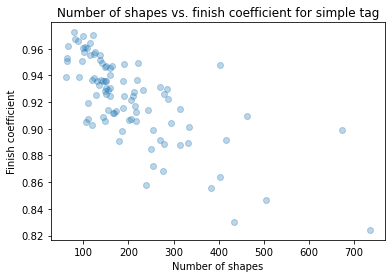

In [50]:
plt.scatter(correlations[correlations.tags=='simple'].totalshapesCount, 
            correlations[correlations.tags=='simple'].finish_coef, alpha=0.3)

left, width = .45, .5
bottom, height = .45, .5
right = left + width
top = bottom + height
ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height, fill=False)
# p.set_transform(ax.transAxes)
# p.set_clip_on(False)
# ax.add_patch(p)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for simple tag')
# ax.text(right, top, 'corr = -0,712', color = 'r',
#         size = 15,
#         horizontalalignment='right',
#         verticalalignment='top',
#         transform=ax.transAxes)

In [ ]:
plt.scatter(clean_dt[clean_dt.category=='simple'].totalshapesCount, 
            clean_dt[clean_dt.category=='simple'].finish_coef, alpha=0.3)

left, width = .45, .5
bottom, height = .45, .5
right = left + width
top = bottom + height
ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height, fill=False)
# p.set_transform(ax.transAxes)
# p.set_clip_on(False)
# ax.add_patch(p)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for simple tag')
# ax.text(right, top, color = 'r',
#         size = 15,
#         horizontalalignment='right',
#         verticalalignment='top',
#         transform=ax.transAxes)

In [ ]:
# Начали красить картинку из тэга all vs. simple
clean_dt[(clean_dt.category=='all') & 
         (clean_dt.picture_id.isin(all_feed[all_feed.tags=='simple'].id.unique().tolist()))][['id', 'finish_coef', 'totalshapesCount', 
                                                                                              'colorsCount']].drop_duplicates().corr(method='spearman')


In [ ]:
plt.scatter(clean_dt[(clean_dt.category=='all') & 
         (clean_dt.picture_id.isin(all_feed[all_feed.tags=='simple'].id.unique().tolist()))].totalshapesCount, 
            clean_dt[(clean_dt.category=='all') & 
         (clean_dt.picture_id.isin(all_feed[all_feed.tags=='simple'].id.unique().tolist()))].finish_coef, alpha=0.3)

# left, width = .45, .5
# bottom, height = .45, .5
# right = left + width
# top = bottom + height
# ax = plt.gca()
# # p = plt.Rectangle((left, bottom), width, height, fill=False)
# # p.set_transform(ax.transAxes)
# # p.set_clip_on(False)
# # ax.add_patch(p)

# plt.xlabel('Number of shapes')
# plt.ylabel('Finish coefficient')
# plt.title('Number of shapes vs. finish coefficient for simple tag')
# ax.text(right, top,  color = 'r',
#         size = 15,
#         horizontalalignment='right',
#         verticalalignment='top',
#         transform=ax.transAxes)

2. Оценить аудиторию, которая красит этот тег. Является ли это отдельным пластом аудитории, которая красит только простые картинки, или это то, с чего юзер начинает и потом конвертируется в обычного пользователя и идет по другим тегам.
3. На какой день пользователь находит тег Simple и начинает его красить, как долго красит его, красит ли другие теги ?
4. Есть ли зависимость, что если человек начинает красить с простых картинок, то он дольше держится в приложении ?
5. Сколько живет пользователь этого тега ? Т.е. может они отваливаются через неделю и тогда нам не интересно это направление.

In [ ]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
with user_launches as (
    select a.customer_user_id, install_day, active_days, inactive_days, launch_number, launch_per_day
    from (
        select customer_user_id, count(distinct event_date) as active_days, 
        date_diff(DATE_ADD(CURRENT_DATE(), INTERVAL -1 DAY), max(event_date), day) as inactive_days,
        count(*) as launch_number,
        count(*)/count(distinct event_date) as launch_per_day
        from `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch`
        group by customer_user_id) as a
    left join (
        select customer_user_id, min(install_day) as install_day 
        from `goingtoclouds.aggregated_data.roas_v4`
        group by customer_user_id) as b
    on a.customer_user_id=b.customer_user_id ),

pic_activity as (
    select a.customer_user_id, started_pics, finished_pics, started_pics/finished_pics as finish_coef
    from (
        SELECT customer_user_id, count(distinct picture_id) as started_pics
        FROM `goingtoclouds.aggregated_data.picture_start` 
        where country != 'Belarus' and customer_user_id not in (31, 0)
        group by customer_user_id) as a
    left join (
        SELECT customer_user_id, count(distinct picture_id) as finished_pics
        FROM `goingtoclouds.aggregated_data.picture_finish` 
        where country != 'Belarus'
        group by customer_user_id
    ) as b
    on a.customer_user_id=b.customer_user_id
)

select pic_activity.customer_user_id, install_day, active_days, inactive_days, 
    launch_number, launch_per_day, started_pics, finished_pics, finish_coef,
    finished_pics/active_days finished_pic_day,
    started_pics/active_days started_pic_day
from pic_activity
left join user_launches
on pic_activity.customer_user_id=user_launches.customer_user_id
'''

activity_pics = client.query(sql, project=project_id).to_dataframe()

In [ ]:
import seaborn as sns

sns.pairplot(activity_pics[['active_days', 'launch_number', 
               'launch_per_day', 'started_pics', 'finished_pics',
               'finish_coef', 'finished_pic_day', 'started_pic_day']])


In [ ]:
plt.scatter(activity_pics.launch_per_day, activity_pics.finished_pic_day, alpha=0.3)

In [ ]:
activity_pics.describe()

In [ ]:
sql = '''
select customer_user_id, tags, count(distinct a.picture_id) as finished_pics_feed
from (
    select customer_user_id, picture_id
    from `goingtoclouds.aggregated_data.picture_finish`
    where country != 'Belarus' and customer_user_id not in (31, 0)) as a
left join (
    select picture_id, 
    if(feed_type='daily_feed', 'daily', tags) as tags
    from `goingtoclouds.feed.all_feed`
) as b 
on a.picture_id=b.picture_id
where tags is not null
group by customer_user_id, tags
'''
finished_pics_feed = client.query(sql, project=project_id).to_dataframe()


sql = '''
select customer_user_id, tags, count(distinct a.picture_id) as started_pics_feed
from (
    select customer_user_id, picture_id
    from `goingtoclouds.aggregated_data.picture_start`
    where country != 'Belarus' and customer_user_id not in (31, 0)) as a
left join (
    select picture_id, 
    if(feed_type='daily_feed', 'daily', tags) as tags
    from `goingtoclouds.feed.all_feed`
) as b 
on a.picture_id=b.picture_id
where tags is not null
group by customer_user_id, tags
'''
started_pics_feed = client.query(sql, project=project_id).to_dataframe()

In [ ]:
sql = '''
with all_category as (
    select customer_user_id, 'all' as category, count(distinct picture_id) as started_pics_category
    from `goingtoclouds.aggregated_data.picture_start`
    where country != 'Belarus' and customer_user_id not in (31, 0) and category = 'all'
    group by customer_user_id
)

select * 
from (select customer_user_id, category, count(distinct picture_id) as started_pics_category
from (
    select customer_user_id, if(tags = 'daily', 'daily', category) as category, a.picture_id, tags
    from (
        select customer_user_id, category, picture_id
        from `goingtoclouds.aggregated_data.picture_start`
        where country != 'Belarus' and customer_user_id not in (31, 0) and category != 'all') as a
    left join (
        select picture_id, 
        if(feed_type='daily_feed', 'daily', tags) as tags
        from `goingtoclouds.feed.all_feed`
    ) as b 
    on a.picture_id=b.picture_id 
    where tags is not null)
where category=tags 
group by customer_user_id, category)

union all 
select * from all_category
'''

started_pics_category = client.query(sql, project=project_id).to_dataframe()

sql = '''
with all_category as (
    select customer_user_id, 'all' as category, count(distinct picture_id) as finished_pics_category
    from `goingtoclouds.aggregated_data.picture_finish`
    where country != 'Belarus' and customer_user_id not in (31, 0) and category = 'all'
    group by customer_user_id
)

select * 
from (select customer_user_id, category, count(distinct picture_id) as finished_pics_category
from (
    select customer_user_id, if(tags = 'daily', 'daily', category) as category, a.picture_id, tags
    from (
        select customer_user_id, category, picture_id
        from `goingtoclouds.aggregated_data.picture_finish`
        where country != 'Belarus' and customer_user_id not in (31, 0) and category != 'all') as a
    left join (
        select picture_id, 
        if(feed_type='daily_feed', 'daily', tags) as tags
        from `goingtoclouds.feed.all_feed`
    ) as b 
    on a.picture_id=b.picture_id 
    where tags is not null)
where category=tags 
group by customer_user_id, category)

union all 
select * from all_category
'''

finished_pics_category = client.query(sql, project=project_id).to_dataframe()

In [ ]:
finished_pics_feed = pd.pivot_table(finished_pics_feed, index='customer_user_id', values='finished_pics_feed', columns='tags').reset_index()
started_pics_feed = pd.pivot_table(started_pics_feed, index='customer_user_id', values='started_pics_feed', columns='tags').reset_index()

finished_pics_category = pd.pivot_table(finished_pics_category, index='customer_user_id', values='finished_pics_category', 
                                        columns='category').reset_index()
started_pics_category = pd.pivot_table(started_pics_category, index='customer_user_id', values='started_pics_category', 
                                       columns='category').reset_index()

finished_pics_category.columns = 'finished_pics_category_' + finished_pics_category.columns  
started_pics_category.columns = 'started_pics_category_' + started_pics_category.columns  
finished_pics_feed.columns = 'finished_pics_feed_' + finished_pics_feed.columns  
started_pics_feed.columns = 'started_pics_feed_' + started_pics_feed.columns 

finished_pics_category.fillna(0, inplace=True)
started_pics_category.fillna(0, inplace=True)
finished_pics_feed.fillna(0, inplace=True)
started_pics_feed.fillna(0, inplace=True)

In [ ]:
activity_pics = activity_pics.merge(finished_pics_category, how='left', left_on='customer_user_id', 
                                    right_on='finished_pics_category_customer_user_id')
activity_pics = activity_pics.merge(started_pics_category, how='left', left_on='customer_user_id', 
                                    right_on='started_pics_category_customer_user_id')
activity_pics = activity_pics.merge(finished_pics_feed, how='left', left_on='customer_user_id', 
                                    right_on='finished_pics_feed_customer_user_id')
activity_pics = activity_pics.merge(started_pics_feed, how='left', left_on='customer_user_id', 
                                    right_on='started_pics_feed_customer_user_id')
activity_pics.drop(['finished_pics_category_customer_user_id', 'started_pics_category_customer_user_id',
                           'finished_pics_feed_customer_user_id','started_pics_feed_customer_user_id'], axis=1, inplace=True)

In [ ]:
activity_pics